# Final Project: Apple Disease Classification
**Based on the Kaggle competition: [Apple Disease Classification](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)**

### Setting up Env

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers
   ! pip install -q transformers[torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Running in local environment...")

Running in Colab...
...Installed required dependencies


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sucesfully set kaggle credentials


### Downloading the data

In [3]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('plant-pathology-2020-fgvc7')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
images	sample_submission.csv  small_images  test.csv  train.csv


In [4]:
#Images are initially all stored in a single folder, for easier compatability with fastAI dataloaders we will split the test and train images into 2 different folders

#Not needed any longer

"""
import os
import shutil

# Create a new folder called test unless it already exists
if not os.path.exists('test'):
    os.mkdir('plant-pathology-2020-fgvc7/test')
    os.mkdir('plant-pathology-2020-fgvc7/train')

# Move all images from the images folder starting with Test_ to a new subfolder called test within plant-pathology-2020-fgvc7
for file_name in os.listdir('plant-pathology-2020-fgvc7/images'):
    if file_name.startswith('Test_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/test')
    elif file_name.startswith('Train_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/train')



"""

"\nimport os\nimport shutil\n\n# Create a new folder called test unless it already exists\nif not os.path.exists('test'):\n    os.mkdir('plant-pathology-2020-fgvc7/test')\n    os.mkdir('plant-pathology-2020-fgvc7/train')\n \n# Move all images from the images folder starting with Test_ to a new subfolder called test within plant-pathology-2020-fgvc7\nfor file_name in os.listdir('plant-pathology-2020-fgvc7/images'):\n    if file_name.startswith('Test_'):\n        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/test')\n    elif file_name.startswith('Train_'):\n        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/train')\n        \n        \n\n"

In [5]:
import timm
from fastai.vision.all import *

image_path = path/'images'
image_files = get_image_files(image_path)

"""
train_path = path/'train'
train_files = get_image_files(train_path)

test_path = path/'test'
test_files = get_image_files(train_path)

"""

"\ntrain_path = path/'train'\ntrain_files = get_image_files(train_path)\n\ntest_path = path/'test'\ntest_files = get_image_files(train_path)\n\n"

In [47]:
#Simply contains the filename of all the images in the given folder
image_files[0:3]

(#3) [Path('plant-pathology-2020-fgvc7/images/Test_319.jpg'),Path('plant-pathology-2020-fgvc7/images/Test_1768.jpg'),Path('plant-pathology-2020-fgvc7/images/Train_1402.jpg')]

Shape of image : (1365, 2048)


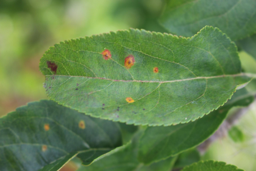

In [48]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

### Inspecting the image sizes


In [6]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

sizes = parallel(check_size, image_files, n_workers=n_cores)
pd.Series(sizes).value_counts()

Number of cores 2


(1365, 2048)    3642
dtype: int64

In [50]:
#sizes = parallel(check_size, test_files, n_workers=n_cores)
#pd.Series(sizes).value_counts()

The images are of similar size, but a few are rotated. To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.

In [7]:
#Function to load images, and if they are in the wrong orientation, rotate them and overwrite

#NOTE Should correct so that it doesn't flip the Test Images as well :-)

def check_transpose(img):
    img_loaded = PILImage.create(img)
    if img_loaded.shape == (2048,1365):
        print('Flipped image: ', img)
        #Transpose the image 90 degrees and overwrite the original image
        img_rotated = img_loaded.rotate(90, expand=True)
        #img_rotated.show()
        #Save the image
        img_rotated.save(img)
        return img_rotated.shape
    else:
        return img_loaded.shape

image_sizes = parallel(check_transpose, image_files, n_workers=n_cores)
print(f'Images size after rotation: {pd.Series(sizes).value_counts()}')

#test_sizes = parallel(check_transpose, test_files, n_workers=n_cores)
#print(f'Test images size after rotation: {pd.Series(sizes).value_counts()}')

Images size after rotation: (1365, 2048)    3642
dtype: int64


### Inspecting the labels and reformating label CSV

In [8]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [9]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [10]:
#path_full = 'plant-pathology-2020-fgvc7/images/'
#df_train['image_path'] = [path_full+image_id+".jpg" for image_id in df_train['image_id']]
#df_train.image_path[0]

In [11]:
df_train.label.value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

As seen we have the multiple_diseases label under-represented in the training set. Later on I will try to augment the training set with more images of multiple_diseases.

### Setting up dataloader

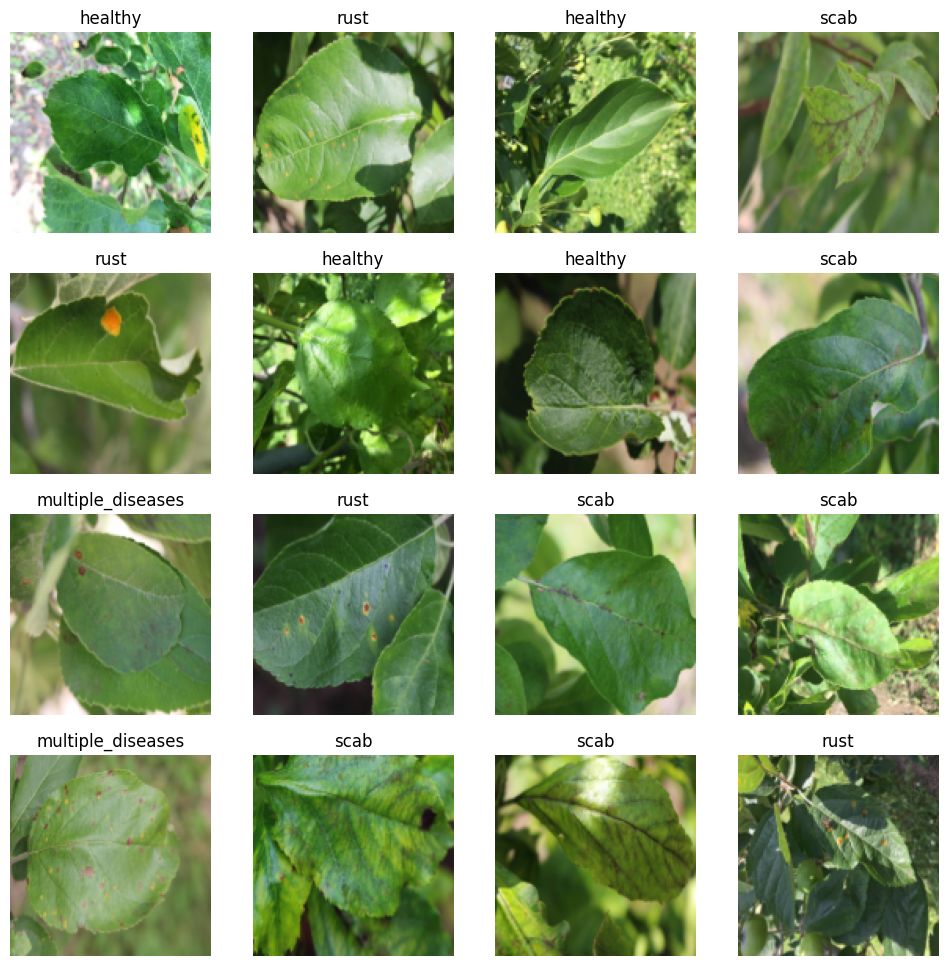

In [13]:
#For Some reason simply adding .jpg to the image_path column doesn't work with the dataloader, so we will use the fastai function to add the suffix instead
#It seems odd that the full path both has to be specified in the fn_column, and that the folder also has to be specified in the folder parameter, but it does not work otherwise..
#When using .from_df it seems like fn_column strictly needs to be the file name, and the folder structure and prefeix needs to be specified in the other parameters

dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'images',
                               suff='.jpg',
                               bs=16,
                               item_tfms=Resize(256, method='squish'),
                               batch_tfms=aug_transforms(size=128, min_scale=0.75),
                               )
dls.show_batch(max_n=16)

# Setting up a simple model
Using convext_tiny, trained on the 22k imagenet

In [14]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


SuggestedLRs(valley=0.0012022644514217973, slide=0.0008317637839354575)

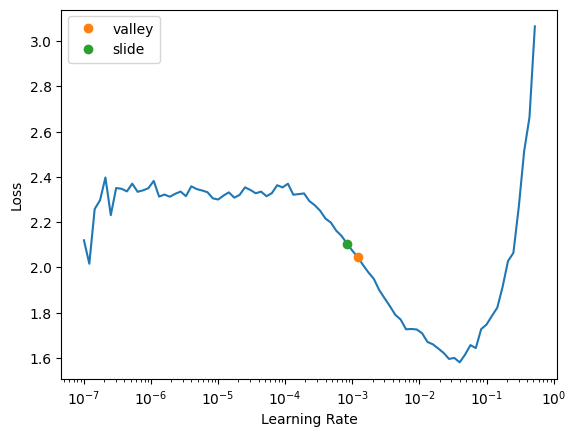

In [15]:
#Searching for an appropriate learning rate
learn.lr_find(suggest_funcs=(valley, slide))

Generally speaking the reccomendations from fastAI is conservative to be on the safe side, so typically one can select a higher LR to speed up the process, as long as one is not too close at the party where LR is too high and we end up overstepping.

In [16]:
#3 epochs, LR= 10^-2
learn.fine_tune(3, 0.005)
#fine_tune = combination of fit_one_cycle(s) + (un)freeze(s) that is found to work well in most fine-tune scenarios.

epoch,train_loss,valid_loss,error_rate,time
0,0.915308,0.647695,0.145604,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.541824,0.312039,0.118132,01:21
1,0.368757,0.252789,0.079670,01:16
2,0.239614,0.199249,0.060440,01:18


In [17]:
#3 epochs, LR= 10^-2
learn.fine_tune(20, 0.005)
#fine_tune = combination of fit_one_cycle(s) + (un)freeze(s) that is found to work well in most fine-tune scenarios.

epoch,train_loss,valid_loss,error_rate,time
0,0.264354,0.361882,0.085165,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.210346,0.229326,0.063187,01:19
1,0.167066,0.191571,0.043956,01:17
2,0.156327,0.218918,0.046703,01:20
3,0.161126,0.246923,0.041209,01:17
4,0.136856,0.274175,0.057692,01:16
5,0.149375,0.329957,0.079670,01:19
6,0.157705,0.286881,0.060440,01:18
7,0.111733,0.227054,0.063187,01:15
8,0.088158,0.217944,0.049451,01:23
9,0.079000,0.275753,0.057692,01:18


At this point, fine-tuning more epochs does not increase accuracy after roughly 3 epochs

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.925226,0.555016,0.156593,01:19


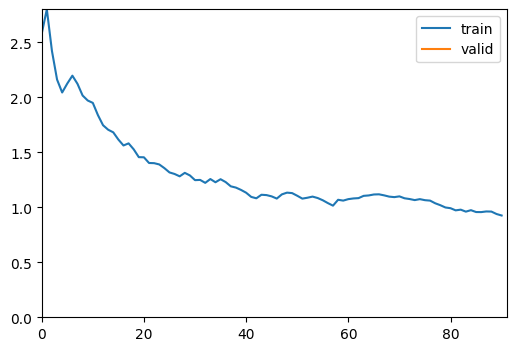

epoch,train_loss,valid_loss,error_rate,time
0,0.444961,0.337489,0.085165,01:16
1,0.422110,0.313457,0.068681,01:19
2,0.296060,0.337896,0.082418,01:21
3,0.157494,0.207814,0.038462,01:23
4,0.083578,0.203241,0.041209,01:22


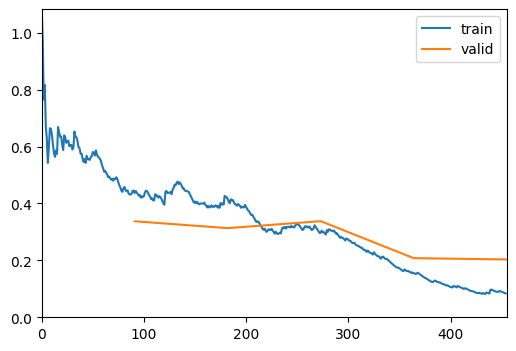

In [19]:
learn2 = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()
learn2.fine_tune(5, 0.01, cbs=[ShowGraphCallback()])

# Preprocessing experiments

## Resizing images
The image_tfms are applied every time we call model_train and due to the large size of images and the limited (2 core) CPU of Google Colab, the iteration process is very slow and has to be called on every model train.

Instead I will resize all the images and save these so that they can be re-used

In [12]:
dest = path/'small_images'
resize_images(path/'images', max_size=512, dest=dest, recurse=True)

In [13]:
#Check the size of a photo in the small_images
image_path_small = path/'small_images'
image_files_small = get_image_files(image_path_small)
sizes = parallel(check_size, image_files_small, n_workers=n_cores)

pd.Series(sizes).value_counts()

(341, 512)    3642
dtype: int64

## Variations of cropping and augmentation

In [26]:
#Function for easily swapping item transform and aug
def train_model(arch, item, batch, epochs=5, learning_rate=0.005):
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  learn.fine_tune(epochs,learning_rate, cbs=[ShowGraphCallback()])
  return learn


**Cropping images**
Method: Crop images to squares

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.018907,0.869015,0.214286,00:15


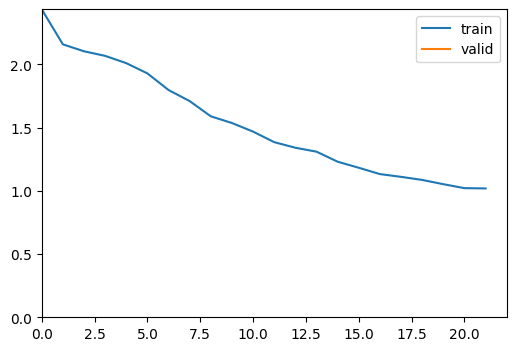

epoch,train_loss,valid_loss,error_rate,time
0,0.501714,0.468498,0.115385,00:14
1,0.385185,0.434946,0.101648,00:14
2,0.312291,0.371747,0.085165,00:13
3,0.267550,0.364898,0.085165,00:11
4,0.218453,0.383724,0.098901,00:14
5,0.176118,0.338441,0.074176,00:15
6,0.164557,0.314899,0.076923,00:14
7,0.136021,0.309212,0.071429,00:14
8,0.109730,0.310161,0.074176,00:12
9,0.097721,0.307387,0.076923,00:12


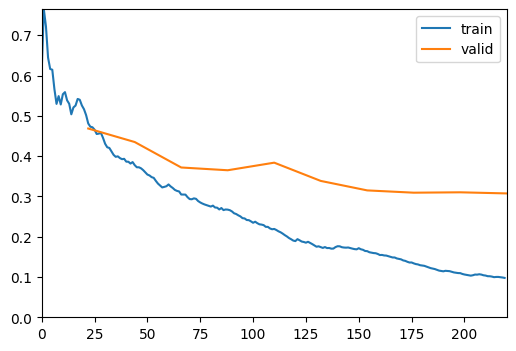

In [57]:
learn = train_model('convnext_small_in22k',
                    item=Resize(256, method='crop'),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=10)

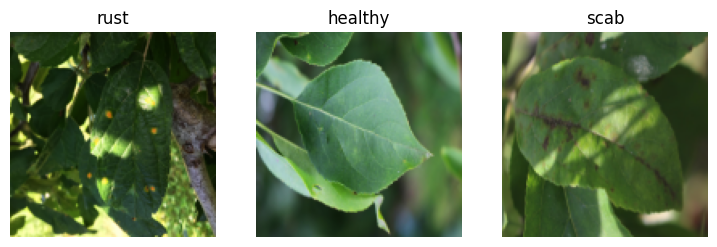

In [34]:
dls.show_batch(max_n=3)

**Squishing images**
Method: Squish images to squares

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.295084,0.836503,0.208791,00:08


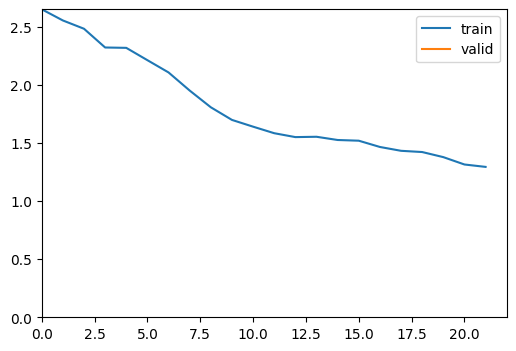

epoch,train_loss,valid_loss,error_rate,time
0,0.527085,0.498276,0.115385,00:08
1,0.428301,0.422760,0.129121,00:09
2,0.360164,0.404374,0.118132,00:08
3,0.311058,0.446373,0.101648,00:08
4,0.263872,0.364804,0.090659,00:09
5,0.212673,0.281225,0.087912,00:09
6,0.167850,0.317054,0.079670,00:10
7,0.134419,0.293193,0.076923,00:07
8,0.113650,0.283682,0.076923,00:10
9,0.094121,0.282956,0.074176,00:09


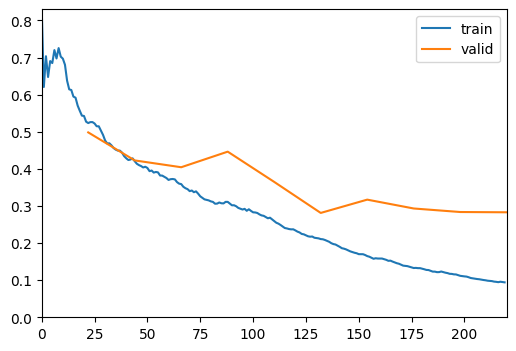

In [30]:
learn = train_model('convnext_small_in22k',
                    item=Resize(170, method='squish'),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=10)

**Maintaining image dimension**
Method: Crop to the image dimension present in the train and validation-set (Not square)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.088849,0.621761,0.120879,00:06


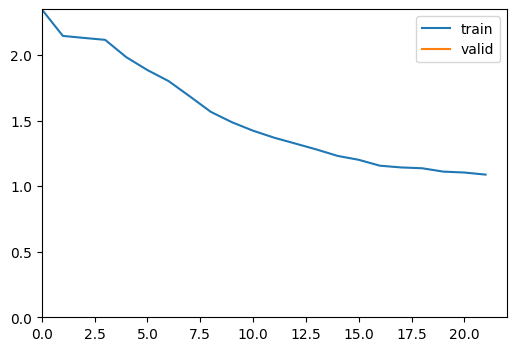

epoch,train_loss,valid_loss,error_rate,time
0,0.534256,0.475908,0.118132,00:09
1,0.426621,0.375400,0.112637,00:07
2,0.360991,0.361077,0.101648,00:10
3,0.305327,0.320510,0.101648,00:12
4,0.251411,0.332848,0.082418,00:11
5,0.205231,0.275634,0.082418,00:11
6,0.163364,0.253188,0.076923,00:09
7,0.129212,0.281303,0.079670,00:09
8,0.116126,0.268769,0.076923,00:10
9,0.096416,0.253182,0.079670,00:08


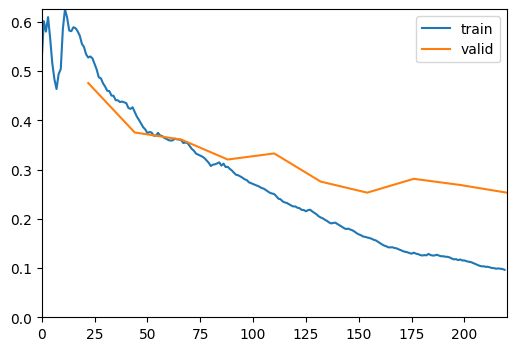

In [35]:
learn = train_model('convnext_small_in22k',
                    item=Resize((170,256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                    batch=aug_transforms(size=128, min_scale=0.75),
                    epochs=10)

**Note regarding dls.show_batch**: dls.show_batch shows the same result, since it shows the images after applying the batch_tfms which resizes 128x128.

To verify that the item_tfms indeed does as intented, a simple dls without batch_tfms is created below

In [40]:
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=Resize((170,256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
  )

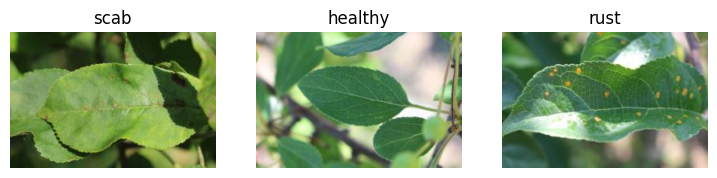

In [41]:
dls.show_batch(max_n=3)

## Testing different models

In [14]:
!pip install pynvml

In [15]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
report_gpu()

GPU:0
no processes are running


In [22]:
res = 341,512

models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),},
    #Vit is transformer based and can only handle fixed input size, hence the first resize
    'vit_large_patch16_224': {
        (Resize(341, method='crop'), 224),
        (Resize(res), 224)},
     #Beit is transformer based and can only handle fixed input size, hence the first resize
    'beitv2_large_patch16_224.in1k_ft_in22k_in1k': {
        (Resize(341, method='crop'), 224),
        (Resize(res), 224)},
}

In [ ]:
res = 341,512

models = {
    'convnext_large_in22k': {
        (Resize(341, method='crop'), 224),
        (Resize(res), (320,224))},
    #Vit is transformer based and can only handle fixed input size, hence the first resize
    'vit_large_patch16_224': {
        (Resize(341, method='crop'), 224),
        (Resize(res), 224)},
     #Beit is transformer based and can only handle fixed input size, hence the first resize
    'beitv2_large_patch16_224.in1k_ft_in22k_in1k': {
        (Resize(341, method='crop'), 224),
        (Resize(res), 224)},
}

In [19]:
#Function for easily swapping item transform and aug
def train_model(arch, b_size, item=Resize(341, method='crop'), epochs=5, learning_rate=0.005,accum=1):
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=aug_transforms(size=b_size, min_scale=0.75), bs=64//accum
                               )
  cbs = GradientAccumulation(64) if accum else []
  learn = vision_learner(dls,arch,metrics=error_rate, cbs=cbs).to_fp16()
  learn.fine_tune(epochs,learning_rate)
  return learn

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (512, 341), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.712990,0.657879,0.126374,00:43


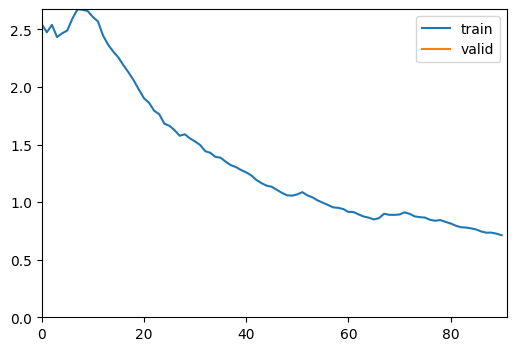

epoch,train_loss,valid_loss,error_rate,time


OutOfMemoryError: ignored

In [23]:
for arch,details in models.items():
    for item,b_size in details:
        print('---',arch)
        print(b_size)
        print(item.name)
        train_model(train_model(arch, b_size, item=item, accum=4, epochs=1)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
#Function for easily swapping item transform and aug
def train_model(arch, item, batch, epochs=5, learning_rate=0.005):
  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'small_images',
                               suff='.jpg',
                               item_tfms=item,
                               batch_tfms=batch,
                               )
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()
  learn.fine_tune(epochs,learning_rate, cbs=[ShowGraphCallback()])
  return learn
